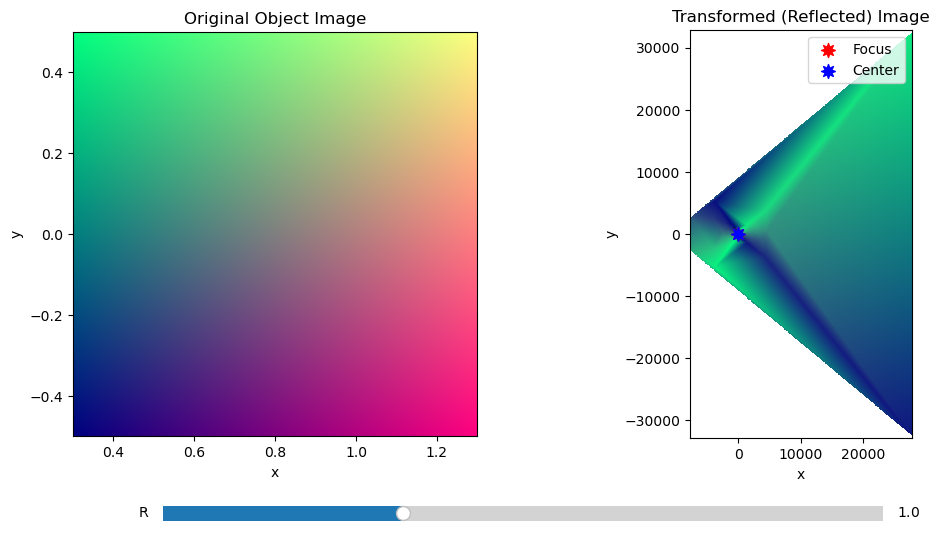

In [1]:
#!/usr/bin/env python
"""
Interactive model for Challenge #8:
Transform an original object image by simulating rays
reflected by a concave spherical mirror.
  
The mirror is defined by the blue arc along the circle
  x^2 + y^2 = R^2,
passing through (0,R), (–R,0), (0,–R).
The center (of curvature) is at (0,0) [blue star],
and the focal point is at (–R/2, 0) [red star].
  
For each pixel (a,b) in the object (with a > 0),
we compute the intersection of:
  • Ray 1: from (a,b) through (0,0) with equation y = (b/a)·x,
  • Ray 2: the horizontal ray at height b from (0,0) goes
           to the mirror at (–√(R²–b²), b) and is reflected
           according to the law of reflection.
           
The reflected ray (Ray 2) is given parametrically by
  x = –√(R²–b²) + t·[(R²–2b²)/R²]
  y =     b        + t·[2b√(R²–b²)/R²]
and solving for the intersection with Ray 1 yields
  t = –R² (a + √(R²–b²)) / [2a√(R²–b²) – (R² – 2b²)].
  
We then use this mapping (a,b) -> (x′, y′) to “push”
the colours from the original image onto the final image.
A griddata–based bilinear interpolation fills the gaps.
  
Adjust the slider to change R.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from matplotlib.widgets import Slider
import matplotlib.path as mpath
import matplotlib.markers as mmarkers

# ---- Helper function to create an 8-pointed star as a custom marker ----
def eight_point_star():
    # Create an 8-point star (by alternating outer and inner vertices)
    outer = 1.0
    inner = 0.5
    num_points = 8
    angles = np.linspace(0, 2*np.pi, 2*num_points, endpoint=False)
    verts = []
    for i, angle in enumerate(angles):
        r = outer if i % 2 == 0 else inner
        verts.append((r * np.cos(angle), r * np.sin(angle)))
    verts.append(verts[0])  # close the star path
    return mpath.Path(verts)

star8 = eight_point_star()

# ---- Transformation function ----
def transform_pixels(A, B, R):
    """
    Given original object coordinates A (x-coord) and B (y-coord) and mirror radius R,
    compute transformed (reflected) coordinates (X_trans, Y_trans) from
    the intersection of two rays:
      (i)  ray from (A,B) through (0,0): y = (B/A)*x
      (ii) ray that starts horizontally from (0,0) at height B,
           meets the mirror at ( -sqrt(R^2-B^2), B ),
           and then is reflected.
           
    Returns (X_trans, Y_trans) of the same shape as A and B.
    """
    # To ensure we can compute sqrt(R^2 - B^2) we clip B values:
    sqrt_term = np.sqrt(np.clip(R**2 - B**2, 0, None))
    # Avoid division-by-zero (object x-coord should be > 0)
    eps = 1e-6
    A_safe = A + eps
    # Parameter t such that the reflected ray (Ray 2) meets Ray 1:
    denom = 2 * A_safe * sqrt_term - (R**2 - 2 * B**2)
    # (The formula is valid where denom != 0.)
    t = - R**2 * (A_safe + sqrt_term) / (denom)
    X_trans = -sqrt_term + t * ((R**2 - 2 * B**2) / R**2)
    Y_trans = B + t * (2 * B * sqrt_term / R**2)
    return X_trans, Y_trans

# ---- Generate a synthetic original image ----
# We set up an object “screen” where the object is placed with x > 0.
# (Here we use coordinates (x,y) ≡ (a,b))
M, N = 200, 300  # image height and width (pixels)
# Let x run from 0.3 to 1.3 and y from -0.5 to 0.5 (object size ~1)
x_vals = np.linspace(0.3, 1.3, N)
y_vals = np.linspace(-0.5, 0.5, M)
A_obj, B_obj = np.meshgrid(x_vals, y_vals)

# Create a colourful gradient image:
img_orig = np.zeros((M, N, 3))
img_orig[..., 0] = (A_obj - x_vals.min()) / (x_vals.max() - x_vals.min())  # red: increases with x
img_orig[..., 1] = (B_obj - y_vals.min()) / (y_vals.max() - y_vals.min())  # green: increases with y
img_orig[..., 2] = 0.5  # blue: constant

# ---- Set up the figure with two subplots ----
# Left: original object; Right: transformed reflection with mirror and stars.
fig, (ax_orig, ax_trans) = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(bottom=0.20, wspace=0.3)

# Display the original image (with axes labelled in "object" coordinates)
ax_orig.imshow(img_orig, extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]], origin='lower')
ax_orig.set_title('Original Object Image')
ax_orig.set_xlabel('x')
ax_orig.set_ylabel('y')
ax_orig.set_aspect('equal')

# Create a placeholder for the transformed image.
# We will interpolate (via griddata) from our scattered transformed pixels.
im_trans = ax_trans.imshow(np.zeros((M, N, 3)), extent=[-1,1,-1,1],
                           origin='lower', aspect='equal')
ax_trans.set_title('Transformed (Reflected) Image')
ax_trans.set_xlabel('x')
ax_trans.set_ylabel('y')

# Plot initial mirror arc and stars (we will update these in our update function)
mirror_line, = ax_trans.plot([], [], color='blue', lw=2)
star_focus = ax_trans.scatter([], [], color='red', marker=star8, s=100, zorder=5,
                              label='Focus')
star_center = ax_trans.scatter([], [], color='blue', marker=star8, s=100, zorder=5,
                               label='Center')
ax_trans.legend(loc='upper right')

# ---- Function to update the transformed image (and mirror/stars) for a given R ----
def update_plot(R):
    # Compute the new transformed coordinates for each object pixel.
    X_trans, Y_trans = transform_pixels(A_obj, B_obj, R)
    
    # For interpolation we need a set of scattered points and color values.
    pts = np.column_stack((X_trans.ravel(), Y_trans.ravel()))
    
    # Determine interpolation grid bounds (we use the convex-hull bounds)
    xmin, xmax = pts[:,0].min(), pts[:,0].max()
    ymin, ymax = pts[:,1].min(), pts[:,1].max()
    # Create a fine regular grid over the bounding box.
    grid_n = 500
    grid_x = np.linspace(xmin, xmax, grid_n)
    grid_y = np.linspace(ymin, ymax, grid_n)
    grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
    
    # Interpolate each colour channel using griddata (linear interpolation)
    red   = griddata(pts, img_orig[..., 0].ravel(), (grid_X, grid_Y), method='linear')
    green = griddata(pts, img_orig[..., 1].ravel(), (grid_X, grid_Y), method='linear')
    blue  = griddata(pts, img_orig[..., 2].ravel(), (grid_X, grid_Y), method='linear')
    img_trans = np.dstack([red, green, blue])
    
    # Update the transformed image display
    im_trans.set_data(img_trans)
    im_trans.set_extent([xmin, xmax, ymin, ymax])
    
    # Update mirror: the mirror is drawn as the blue arc along
    # the circle x^2 + y^2 = R^2 from (0,R) [theta=pi/2] to (–R,0) [theta=pi] to (0,–R) [theta=3pi/2].
    theta = np.linspace(np.pi/2, 3*np.pi/2, 200)
    arc_x = R * np.cos(theta)
    arc_y = R * np.sin(theta)
    mirror_line.set_data(arc_x, arc_y)
    
    # Update stars:
    # Blue star at the center (0,0)
    star_center.set_offsets(np.array([[0, 0]]))
    # Red star (focus) at (–R/2, 0)
    star_focus.set_offsets(np.array([[-R/2, 0]]))
    
    # Label the axes with a little margin.
    ax_trans.set_xlim(xmin, xmax)
    ax_trans.set_ylim(ymin, ymax)
    
    fig.canvas.draw_idle()

# ---- Initialize with an initial R value; here we start with R = 1.0 ----
R_init = 1.0
update_plot(R_init)

# ---- Set up a slider to control the mirror’s radius R ----
ax_slider = plt.axes([0.20, 0.05, 0.60, 0.05])
slider_R = Slider(ax_slider, 'R', 0.5, 2.0, valinit=R_init, valstep=0.01)

def slider_update(val):
    new_R = slider_R.val
    update_plot(new_R)

slider_R.on_changed(slider_update)

plt.show()